In [6]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bbknn
import pooch

from pathlib import Path
from matplotlib.pyplot import rc_context

In [2]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 2
sc.logging.print_header()

/tmp/ipykernel_504/1483541900.py:3: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


pooch	1.8.2 (v1.8.2)
----	----
kiwisolver	1.4.8
pytz	2025.2
tornado	6.5.1
setuptools	80.9.0
llvmlite	0.44.0
annoy	1.17.3
wcwidth	0.2.13
cycler	0.12.1
asttokens	3.0.0
parso	0.8.4
umap-learn	0.5.9.post2
pickleshare	0.7.5
decorator	5.2.1
jedi	0.19.2
charset-normalizer	3.4.2
natsort	8.4.0
executing	2.2.0
tqdm	4.67.1
pillow	11.3.0
prompt_toolkit	3.0.51
stack_data	0.6.3
cffi	1.17.1
python-dateutil	2.9.0.post0
ipython	8.37.0
joblib	1.5.1
numba	0.61.2
matplotlib-inline	0.1.7
psutil	7.0.0
pure_eval	0.2.3
h5py	3.14.0
six	1.17.0
pycparser	2.22
pynndescent	0.5.13
debugpy	1.8.16
----	----
Python	3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
OS	Linux-5.15.0-1044-aws-x86_64-with-glibc2.27
CPU	16 logical CPU cores, x86_64
GPU	No GPU found
Updated	2025-08-17 10:45

In [3]:
pbmc = sc.datasets.pbmc68k_reduced()
pbmc

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
sc.settings.figdir = "../plots_tut"

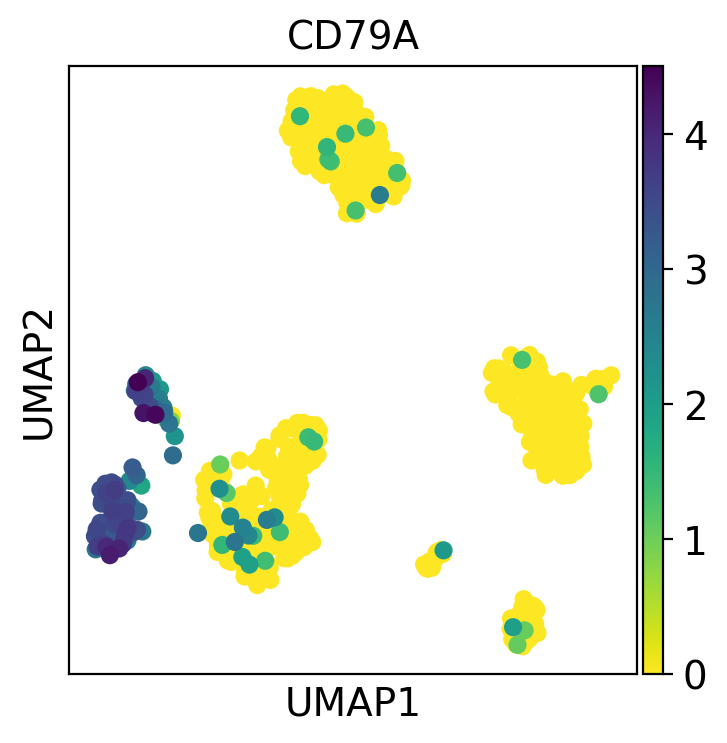

In [9]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(pbmc, color="CD79A", save = "_tut_CD79A")

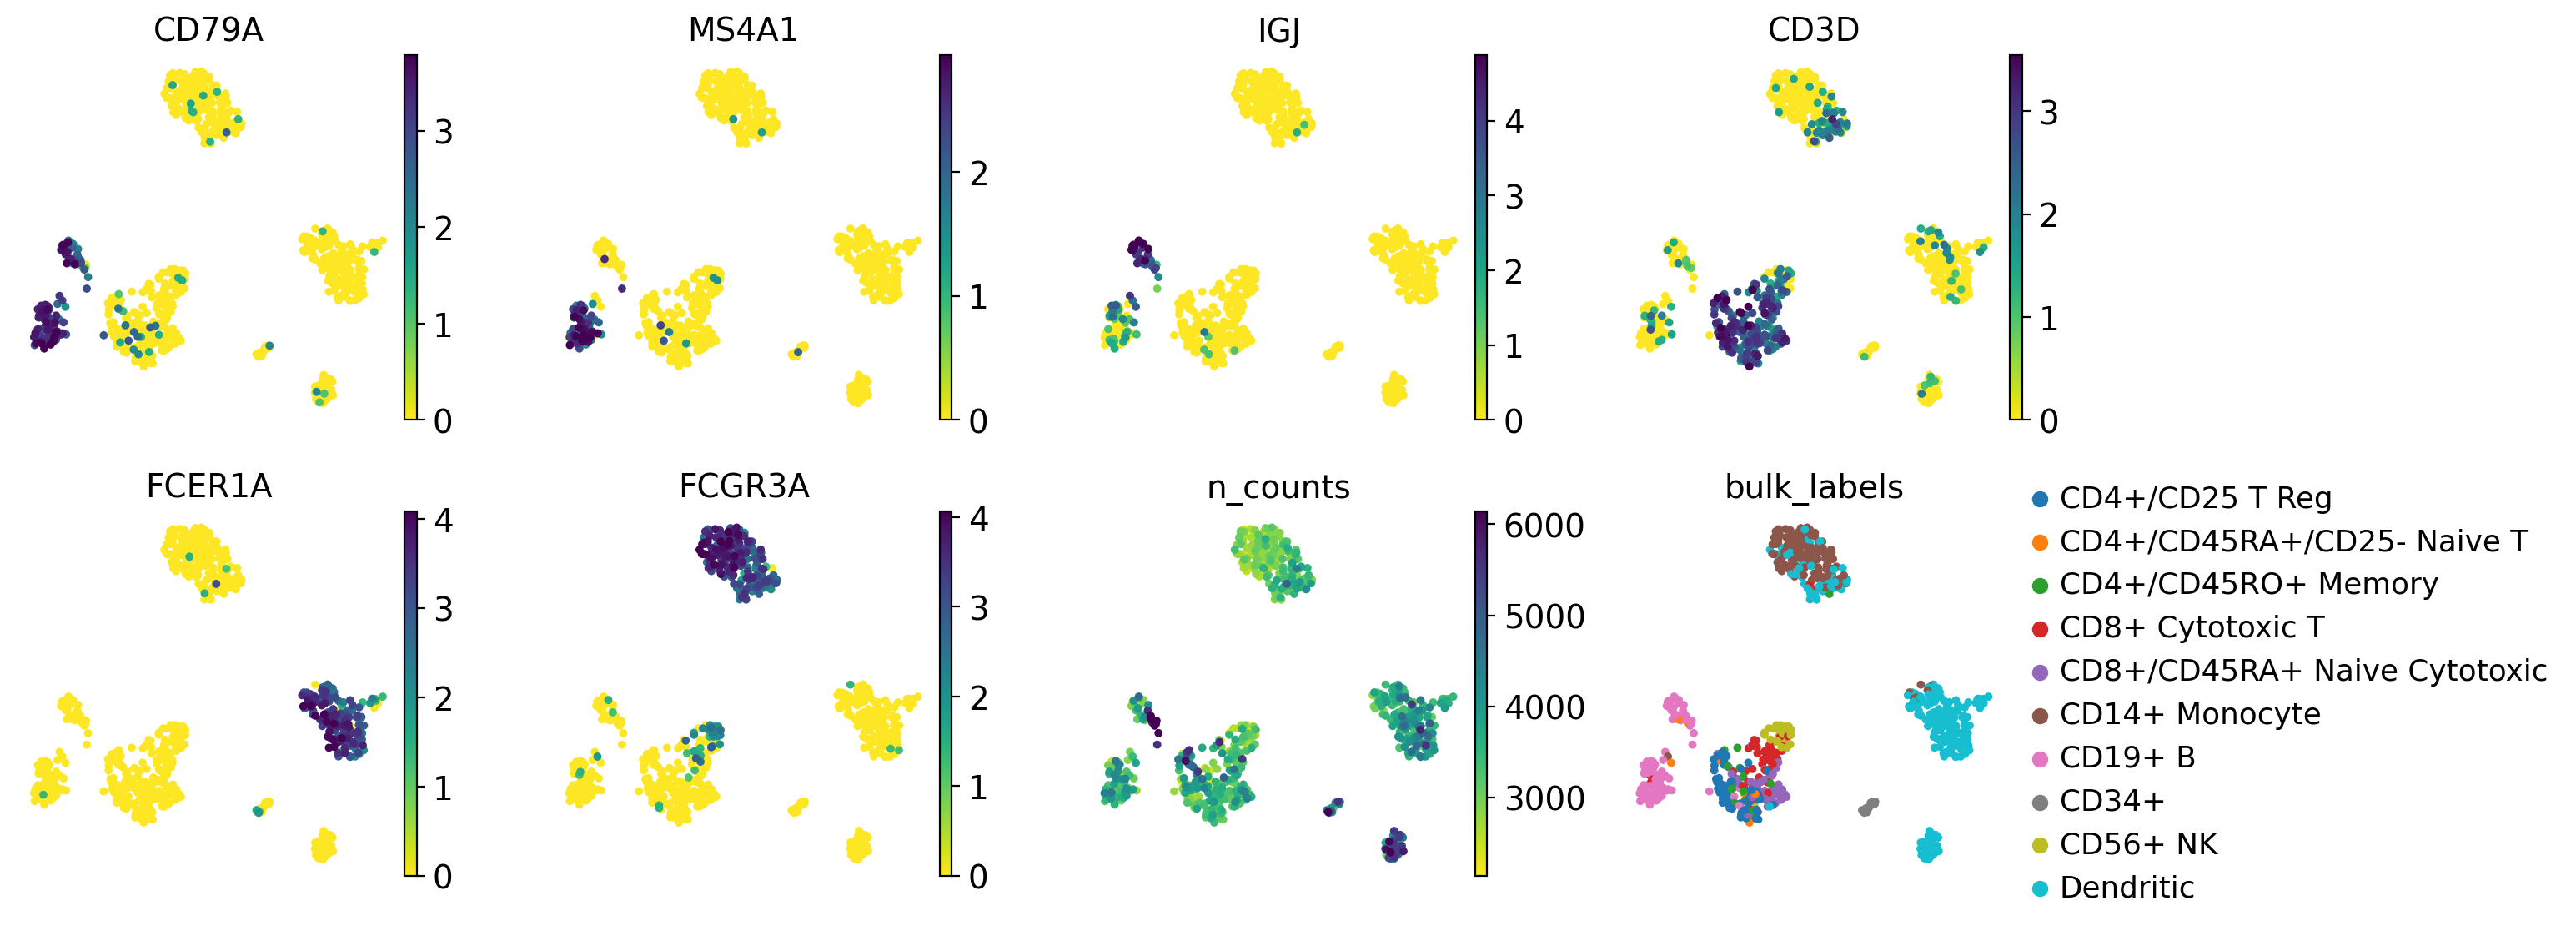

In [8]:
color_vars = [
    "CD79A",
    "MS4A1",
    "IGJ",
    "CD3D",
    "FCER1A",
    "FCGR3A",
    "n_counts",
    "bulk_labels",
]
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(pbmc, color=color_vars, s=50, frameon=False, ncols=4, vmax="p99", save = "_tut_colorvars")

In [10]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    pbmc,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

running Leiden clustering
    finished (0:00:00)


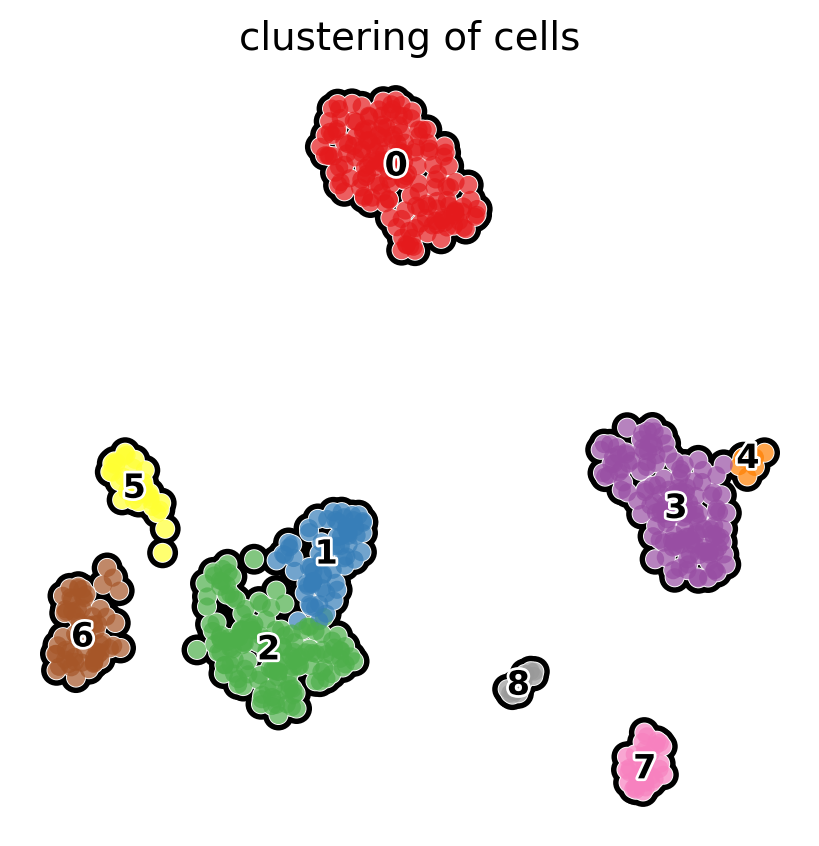

In [11]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
        save = "_tut_clusters"
    )

In [12]:
marker_genes_dict = {
    "B-cell": ["CD79A", "MS4A1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Monocytes": ["FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Other": ["IGLL1"],
    "Plasma": ["IGJ"],
    "T-cell": ["CD3D"],
}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


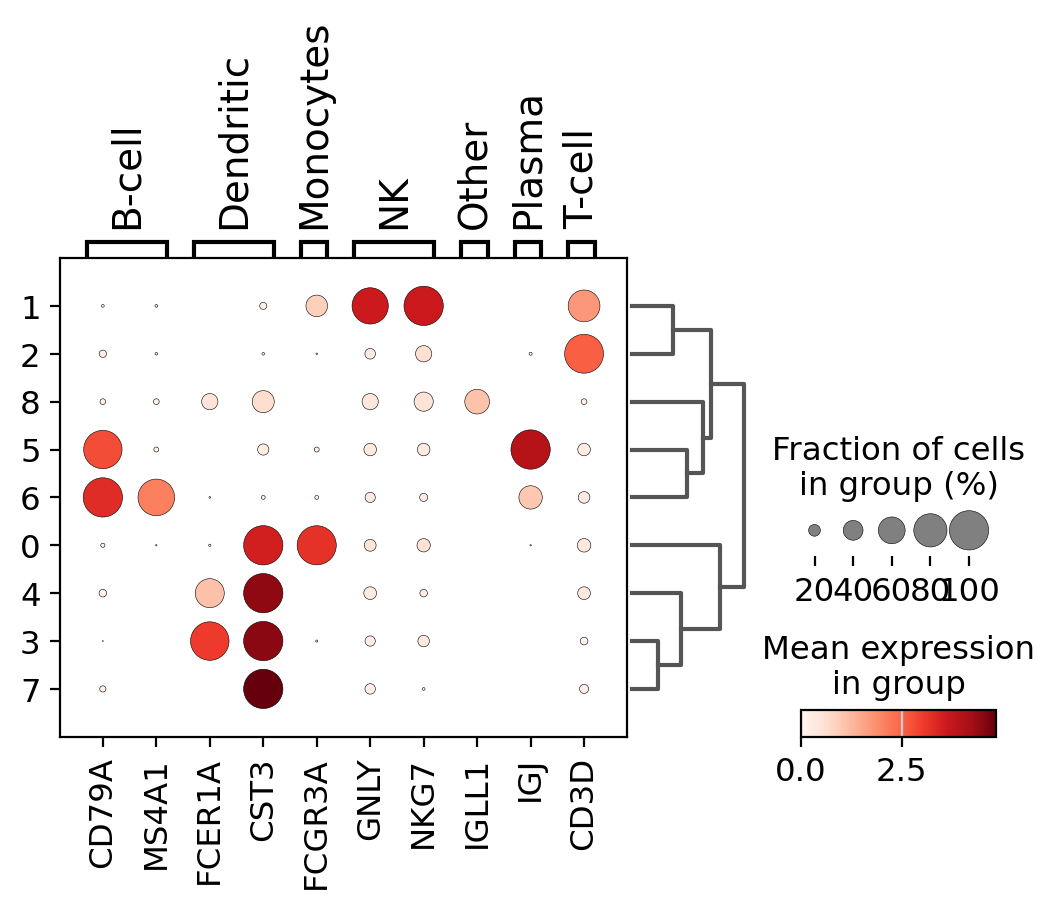

In [13]:
sc.pl.dotplot(pbmc, marker_genes_dict, "clusters", dendrogram=True, save = "_tut_clusters")

In [14]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "0": "Monocytes",
    "1": "NK",
    "2": "T-cell",
    "3": "Dendritic",
    "4": "Dendritic",
    "5": "Plasma",
    "6": "B-cell",
    "7": "Dendritic",
    "8": "Other",
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs["cell type"] = pbmc.obs["clusters"].map(cluster2annotation).astype("category")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`


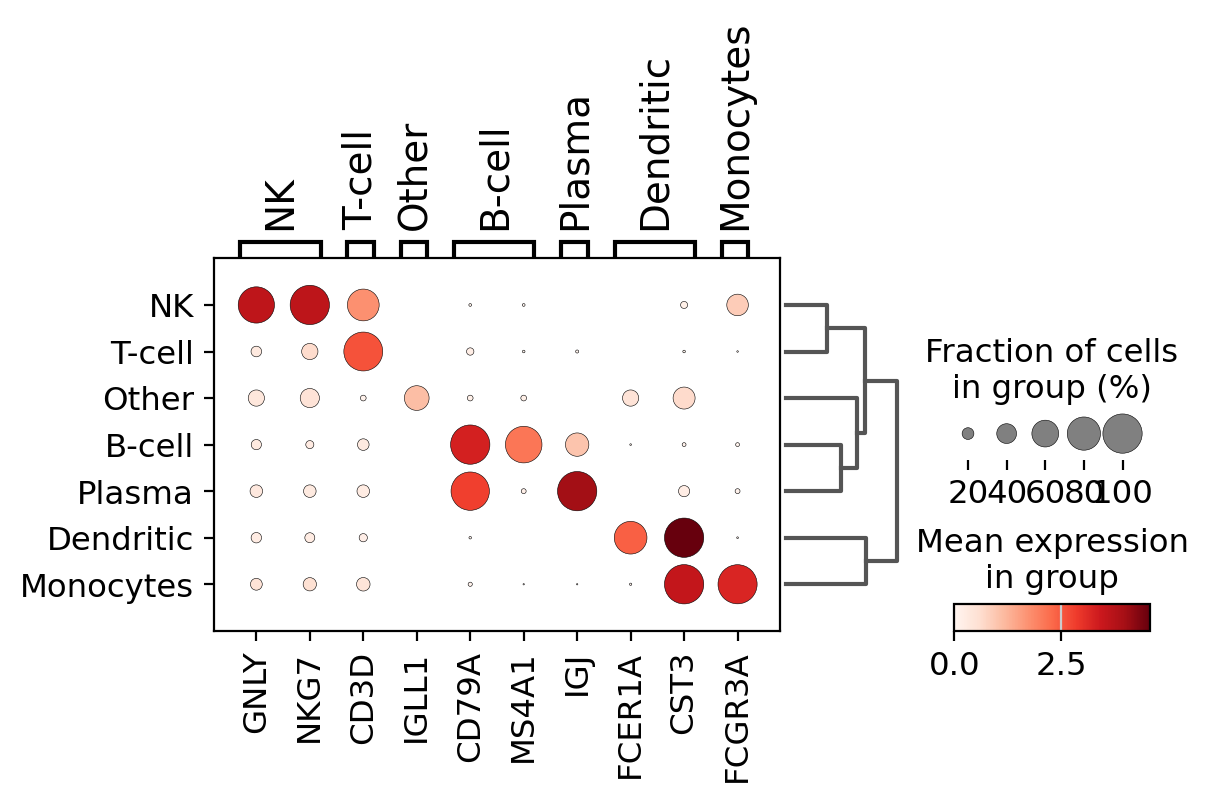

In [15]:
sc.pl.dotplot(pbmc, marker_genes_dict, "cell type", dendrogram=True, save = "_tut_celltype")

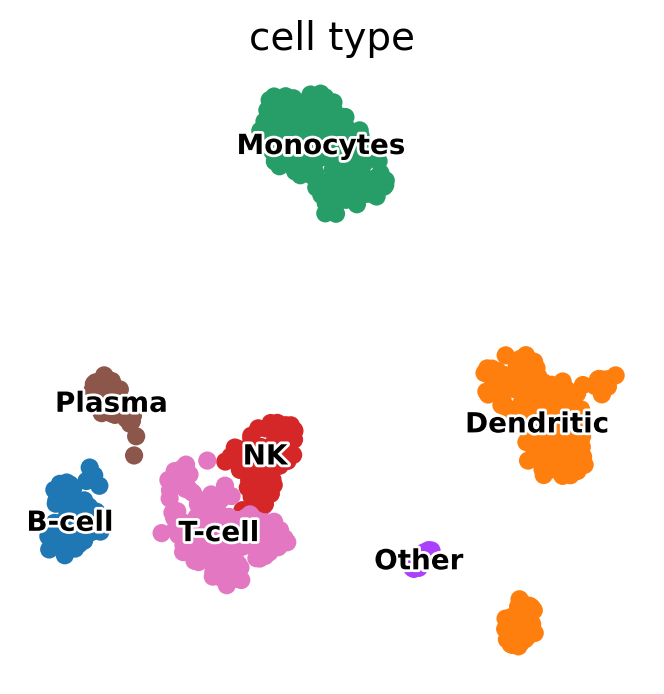

In [25]:
sc.pl.umap(
    pbmc,
    color="cell type",
    legend_loc="on data",
    frameon=False,
    legend_fontsize=10,
    legend_fontoutline=2,
    save = "_tut_celltype"
)

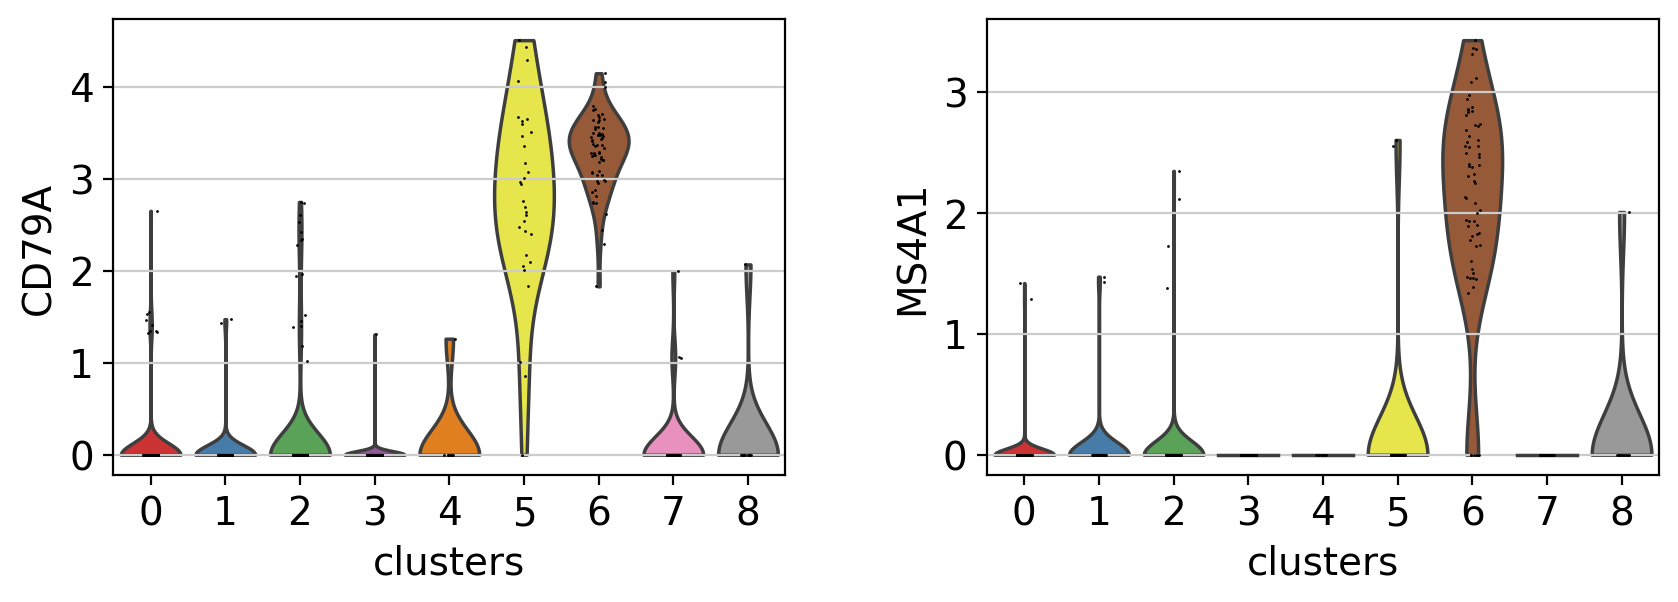

In [17]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(pbmc, ["CD79A", "MS4A1"], groupby="clusters", save = "_tut_CD79A_MS4A1")

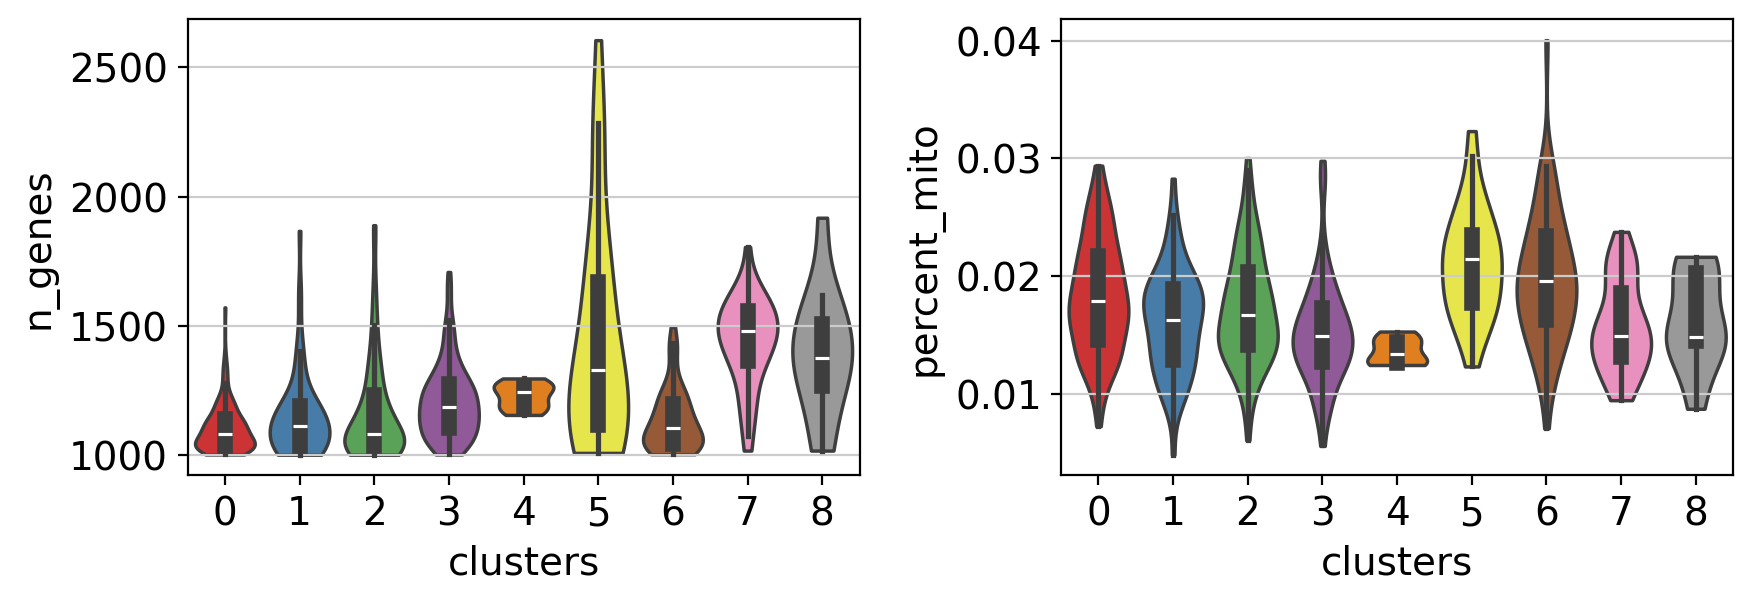

In [18]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(
        pbmc,
        ["n_genes", "percent_mito"],
        groupby="clusters",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
        save = "_tut_clusters"
    )

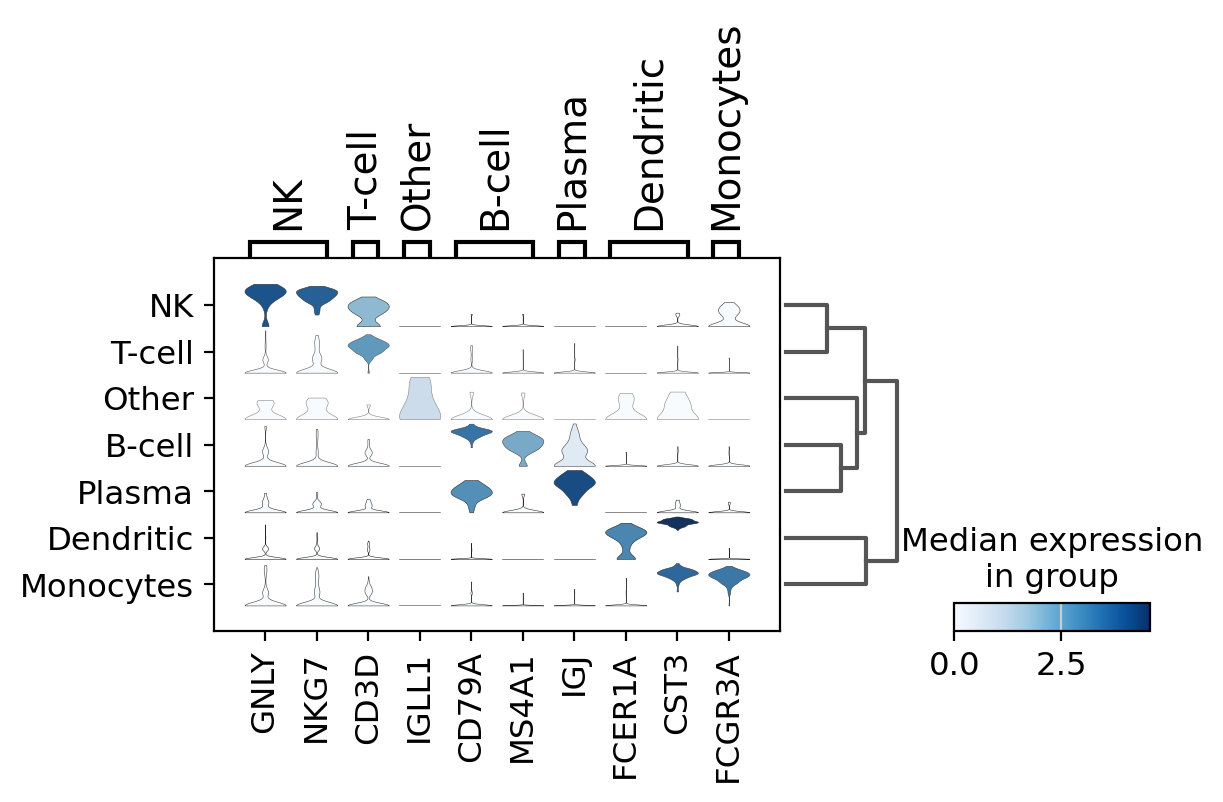

In [19]:
ax = sc.pl.stacked_violin(
    pbmc, marker_genes_dict, groupby="cell type", swap_axes=False, dendrogram=True, save = "_tut_cell type"
)

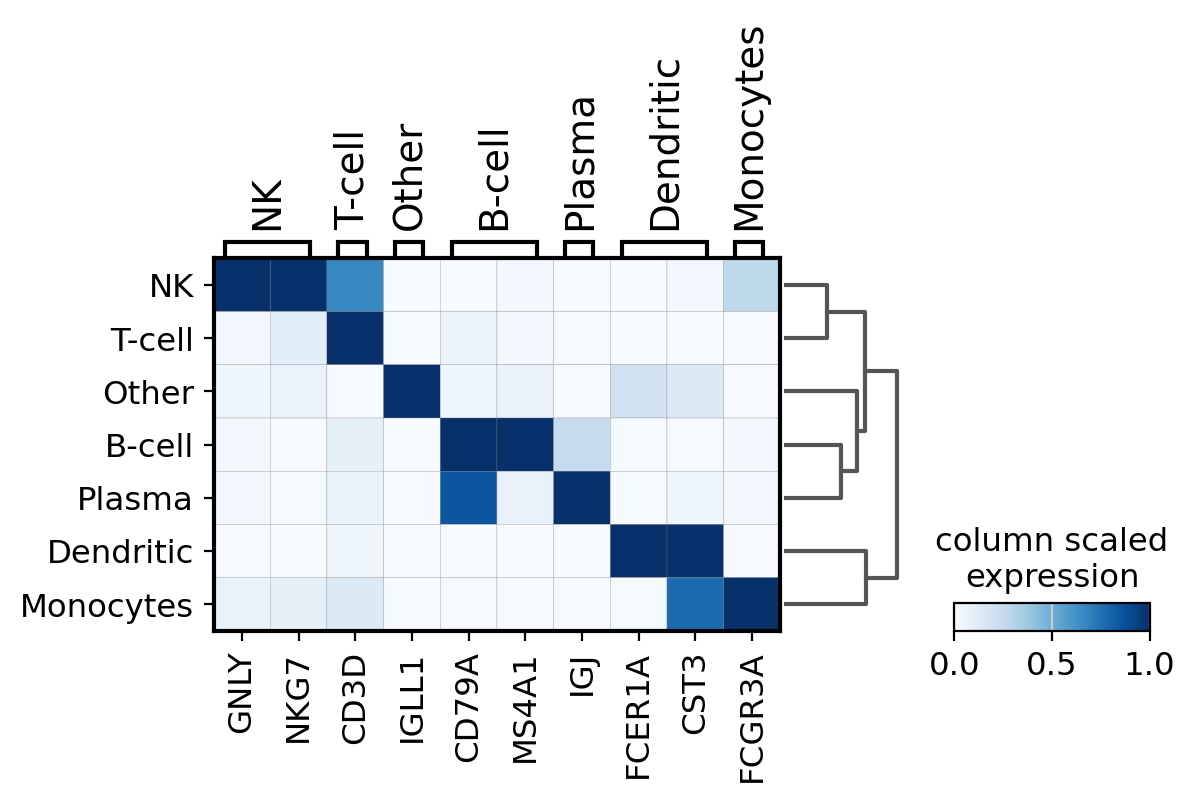

In [43]:
sc.pl.matrixplot(
    pbmc,
    marker_genes_dict,
    "cell type",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    save = "_tut_celltype"
)

In [21]:
# scale and store results in layer
pbmc.layers["scaled"] = sc.pp.scale(pbmc, copy=True).X

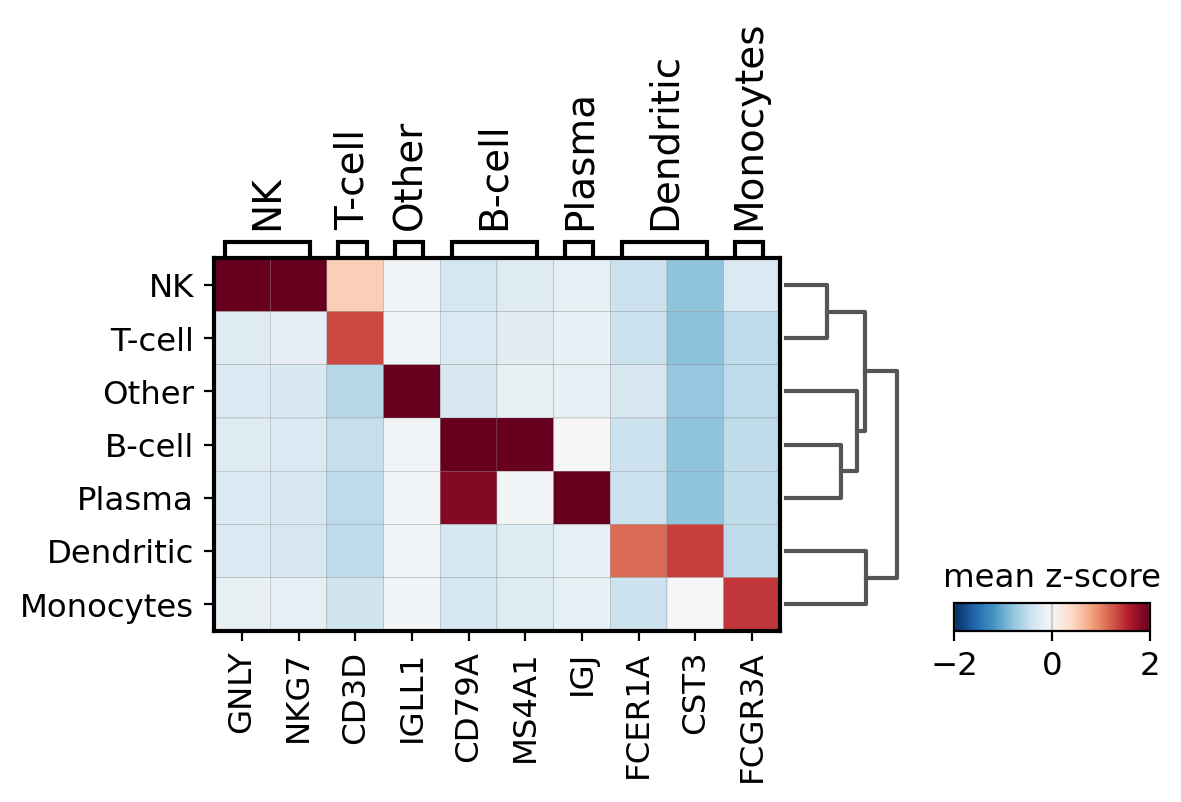

In [42]:
sc.pl.matrixplot(
    pbmc,
    marker_genes_dict,
    "cell type",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    save = "_tut_celltype_scaled"
)

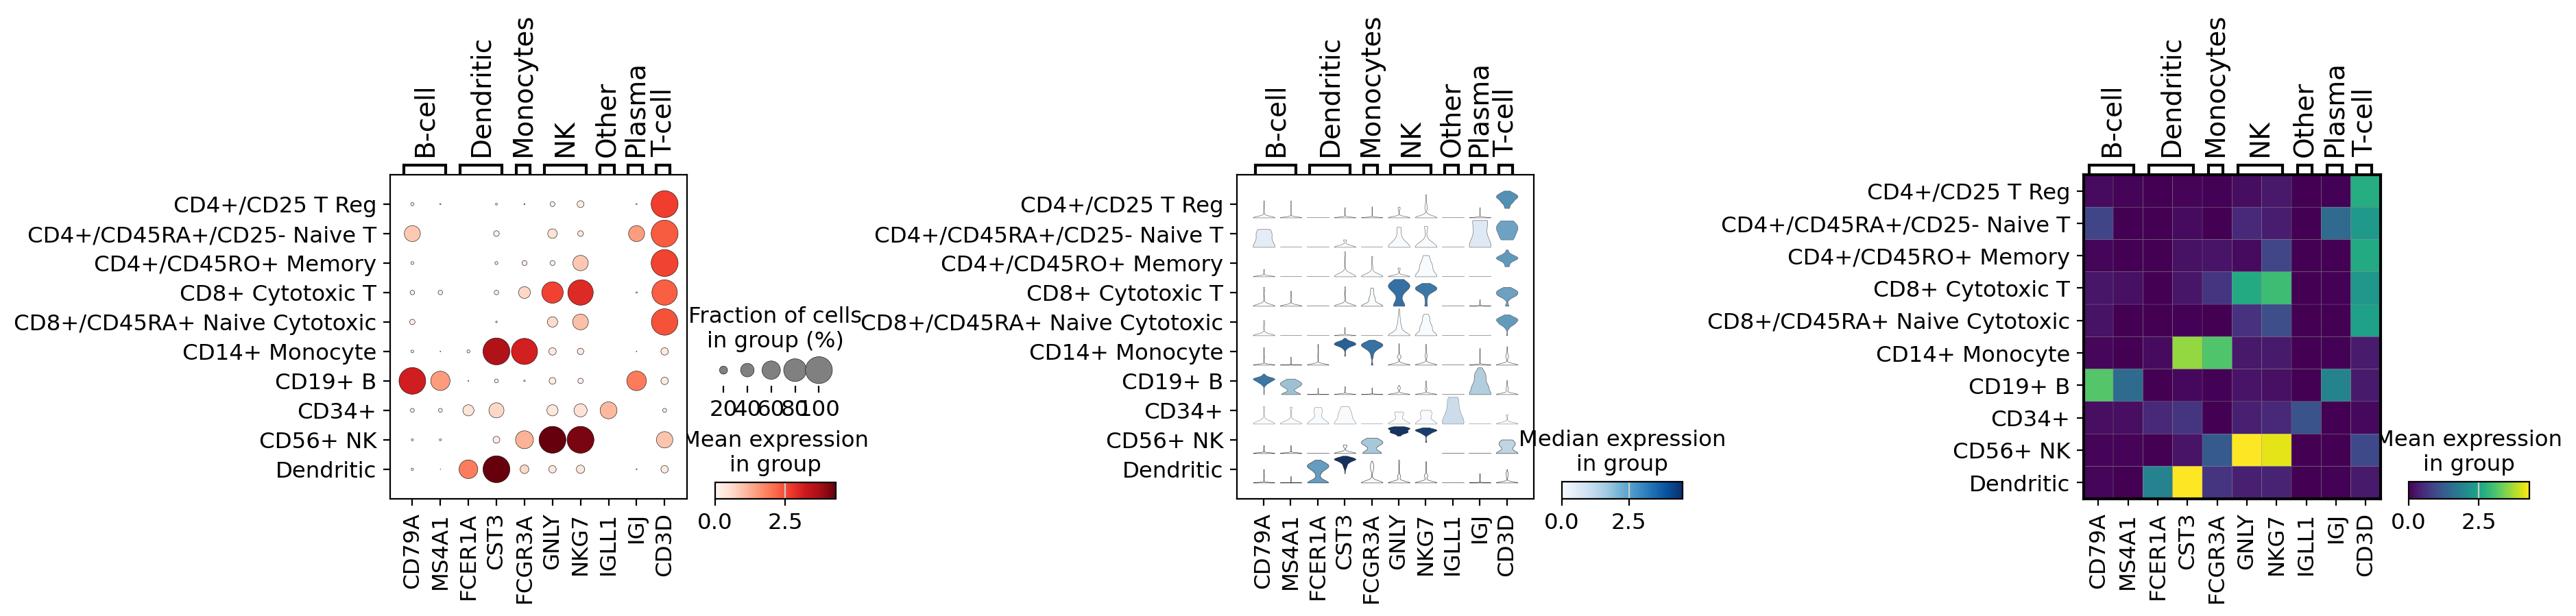

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4), gridspec_kw={"wspace": 0.9})

ax1_dict = sc.pl.dotplot(
    pbmc, marker_genes_dict, groupby="bulk_labels", ax=ax1, show=False
)
ax2_dict = sc.pl.stacked_violin(
    pbmc, marker_genes_dict, groupby="bulk_labels", ax=ax2, show=False
)
ax3_dict = sc.pl.matrixplot(
    pbmc, marker_genes_dict, groupby="bulk_labels", ax=ax3, show=False, cmap="viridis"
)

plt.savefig("../plots_tut/combined_plot_tut_bulklabels.pdf", dpi=300, bbox_inches="tight")

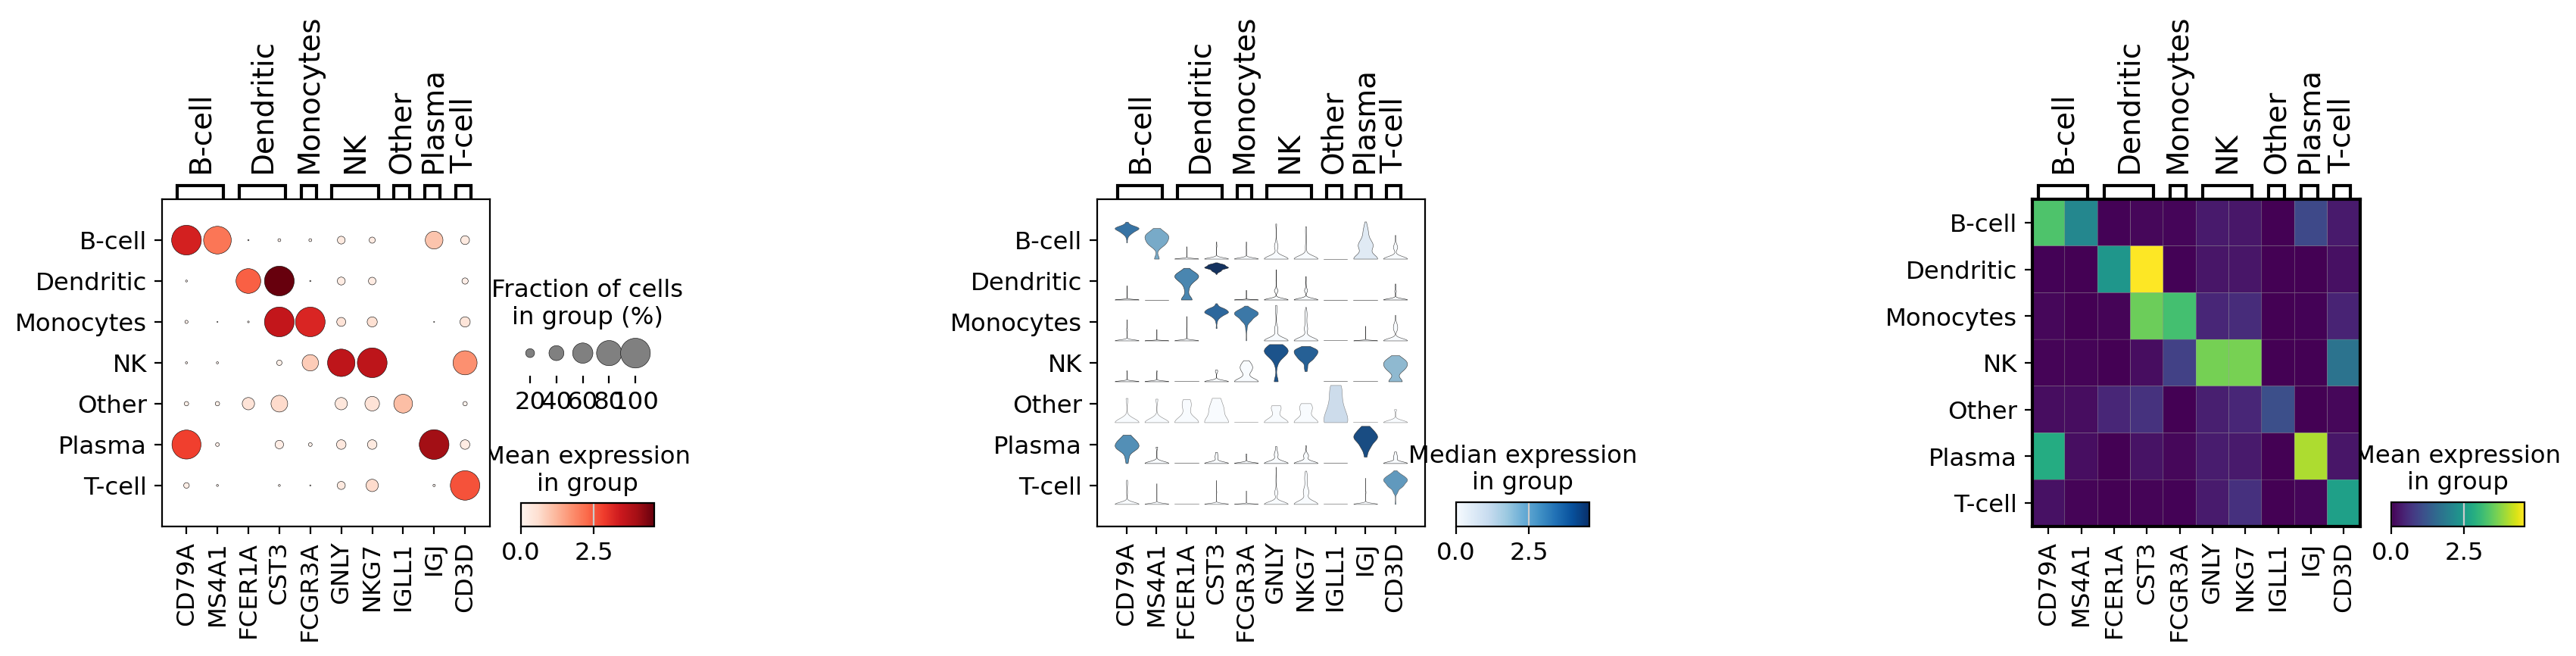

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4), gridspec_kw={"wspace": 0.9})

ax1_dict = sc.pl.dotplot(
    pbmc, marker_genes_dict, groupby="cell type", ax=ax1, show=False
)
ax2_dict = sc.pl.stacked_violin(
    pbmc, marker_genes_dict, groupby="cell type", ax=ax2, show=False
)
ax3_dict = sc.pl.matrixplot(
    pbmc, marker_genes_dict, groupby="cell type", ax=ax3, show=False, cmap="viridis"
)

plt.savefig("../plots_tut/combined_plot_tut_celltype.pdf", dpi=300, bbox_inches="tight")

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


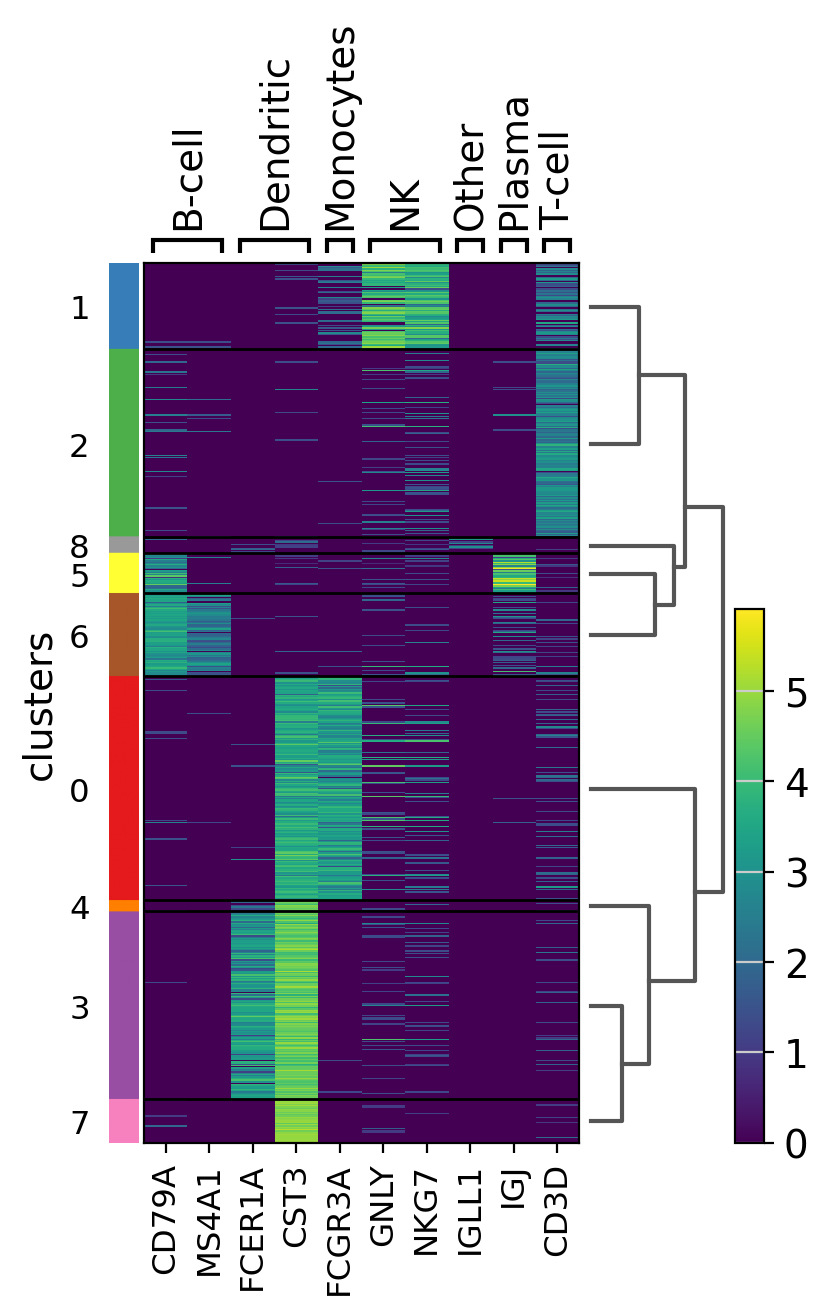

In [30]:
ax = sc.pl.heatmap(
    pbmc, marker_genes_dict, groupby="clusters", cmap="viridis", dendrogram=True, save = "_tut_clusters"
)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


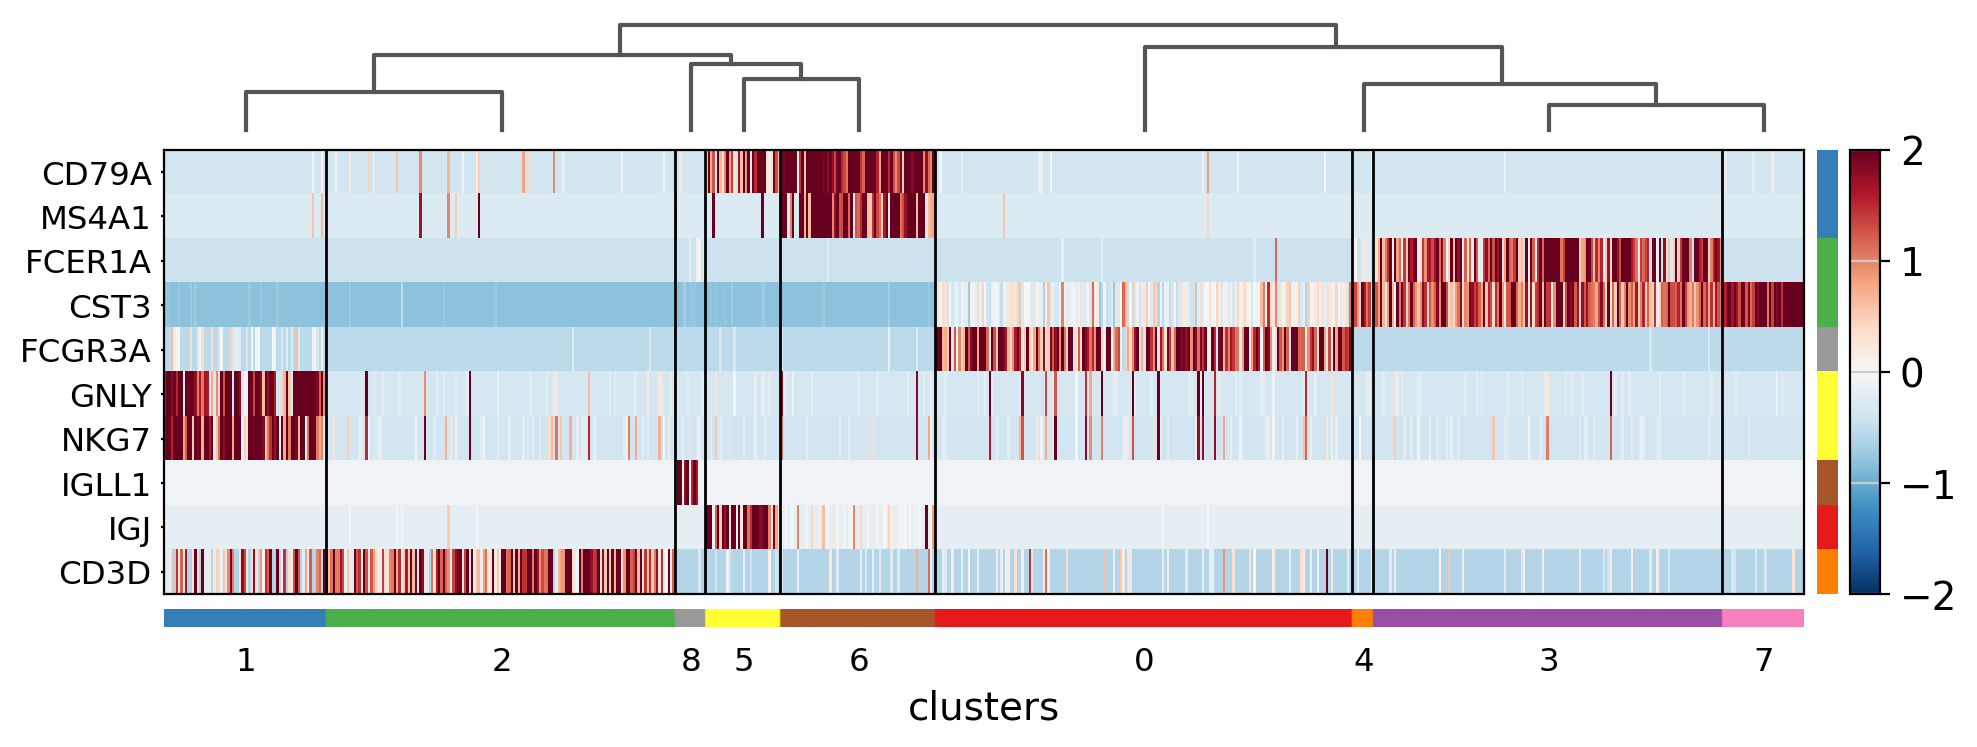

In [31]:
ax = sc.pl.heatmap(
    pbmc,
    marker_genes_dict,
    groupby="clusters",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 4),
    save="_tut_clusters"
)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


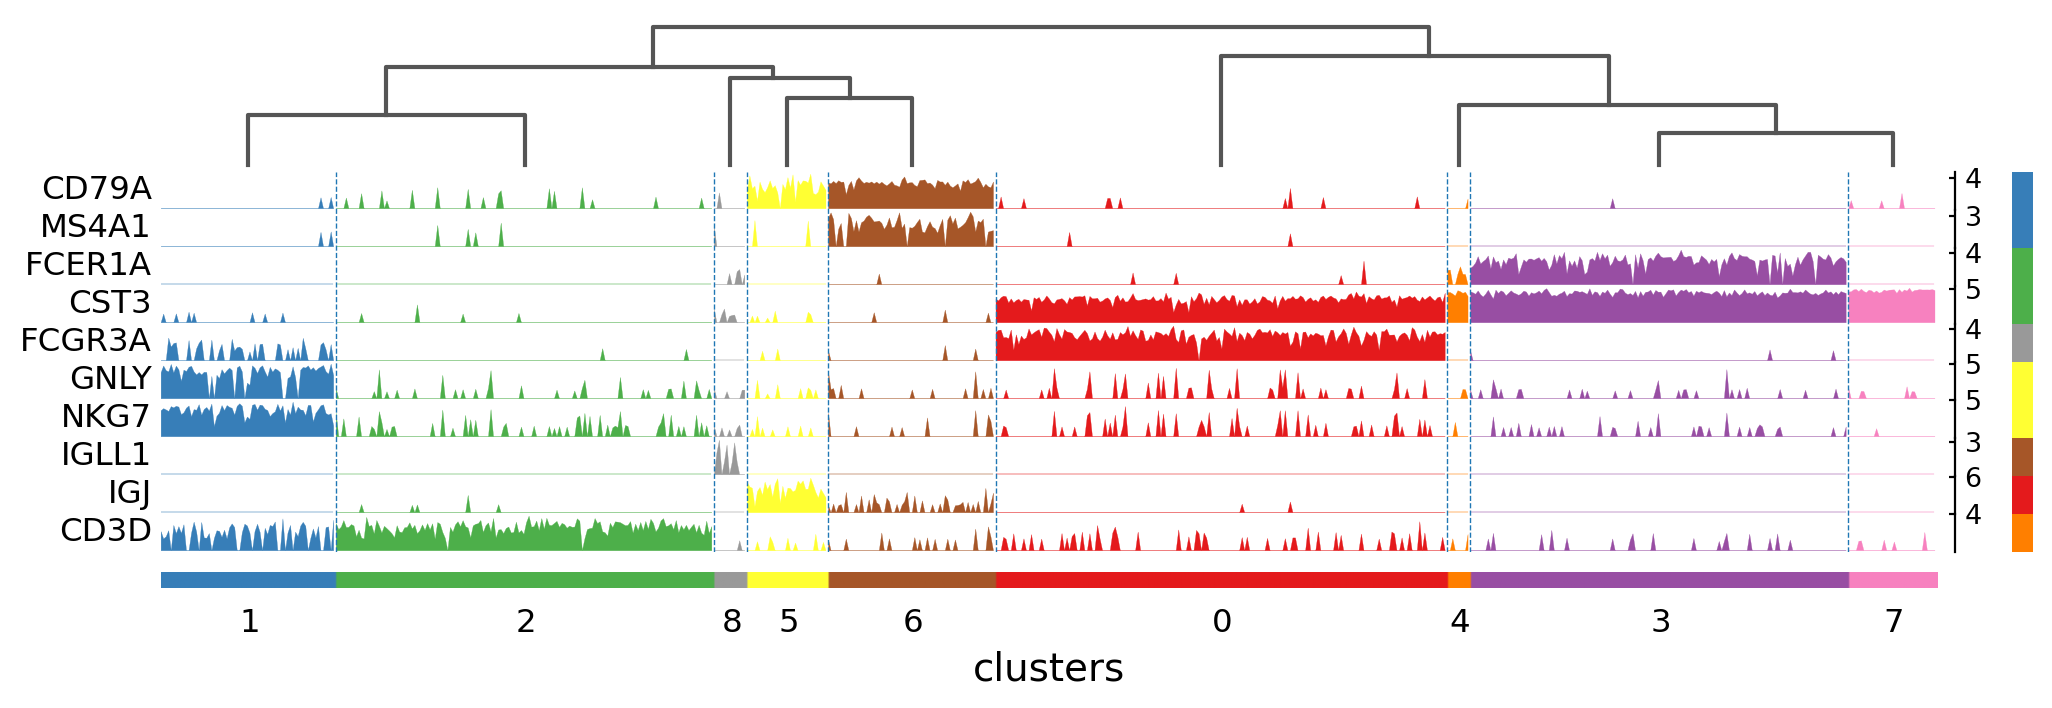

In [32]:
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby="clusters", dendrogram=True, save="_tut_clusters")

In [33]:
sc.tl.rank_genes_groups(pbmc, groupby="clusters", method="wilcoxon")

ranking genes
    finished (0:00:00)


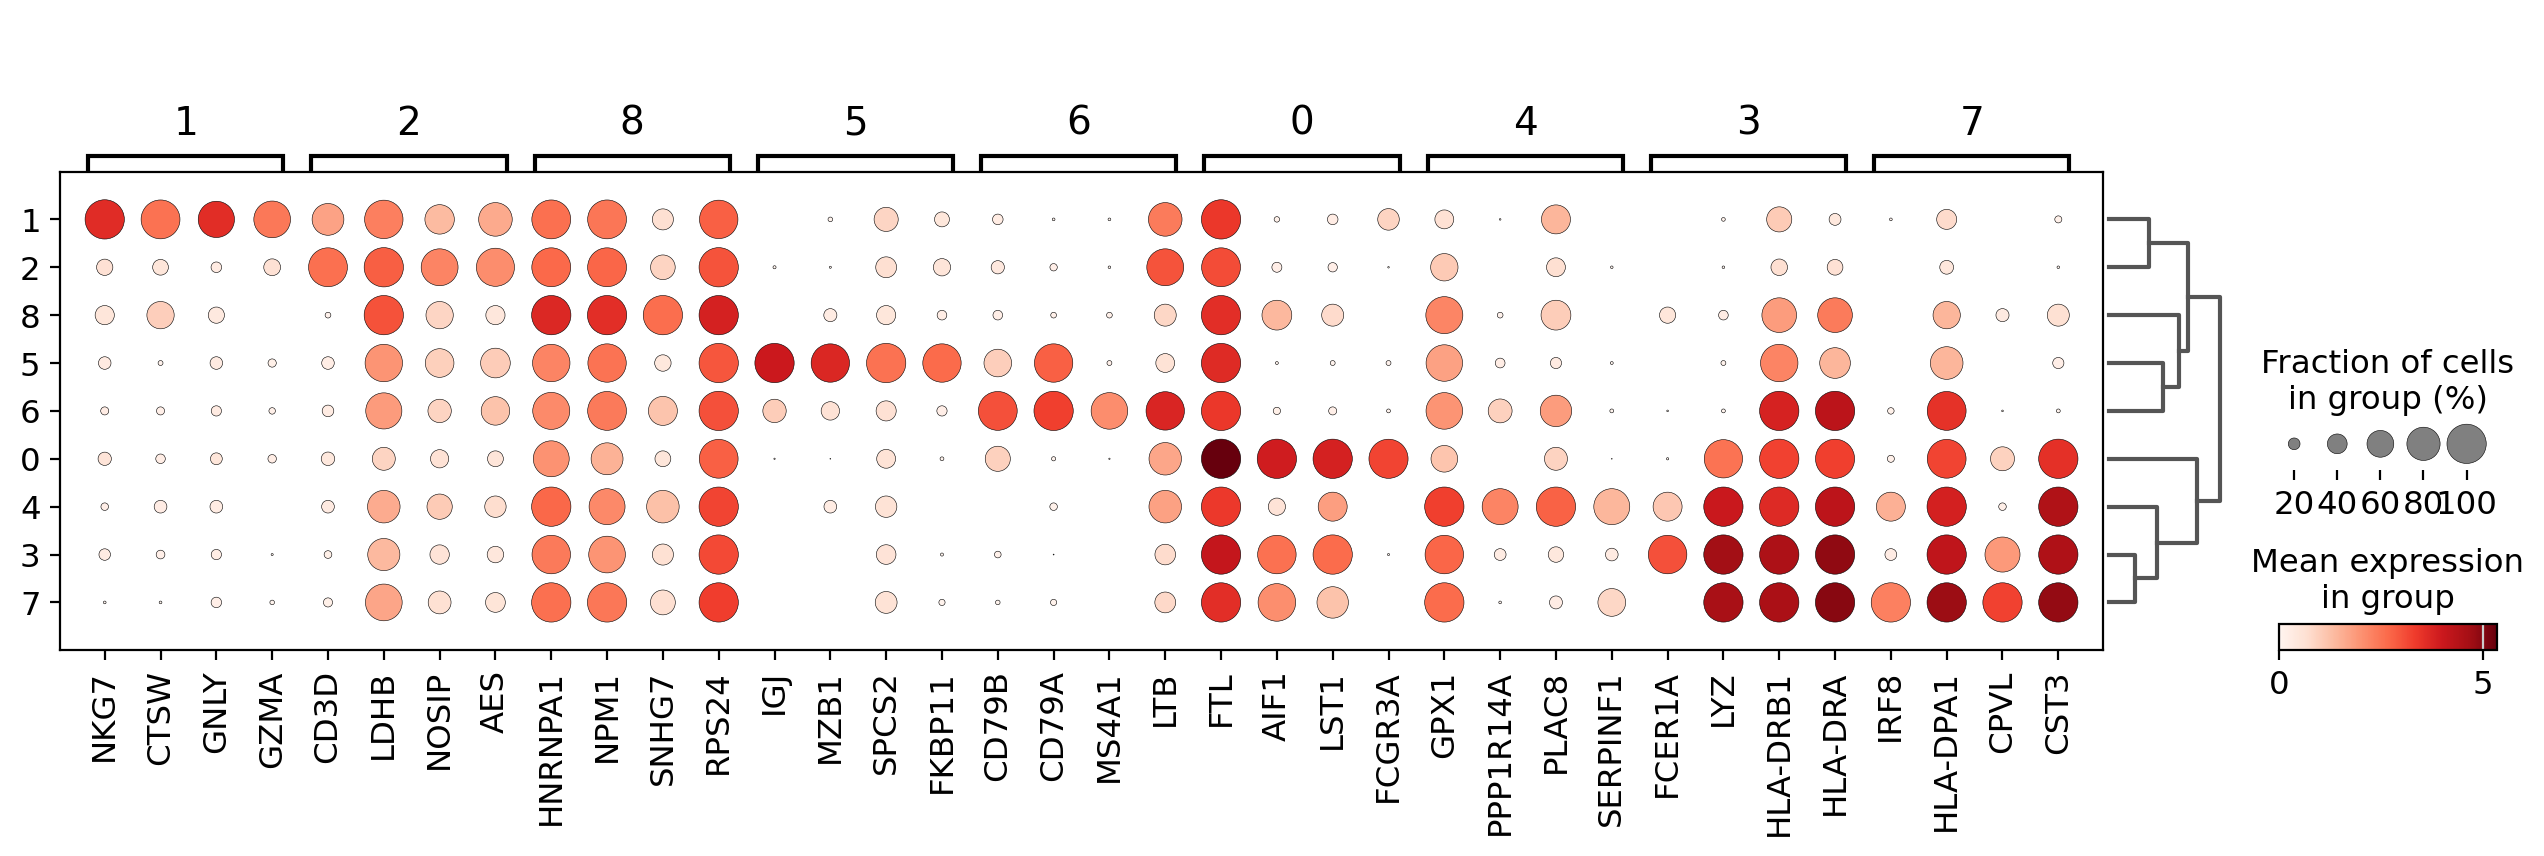

In [36]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4, save="_tut")

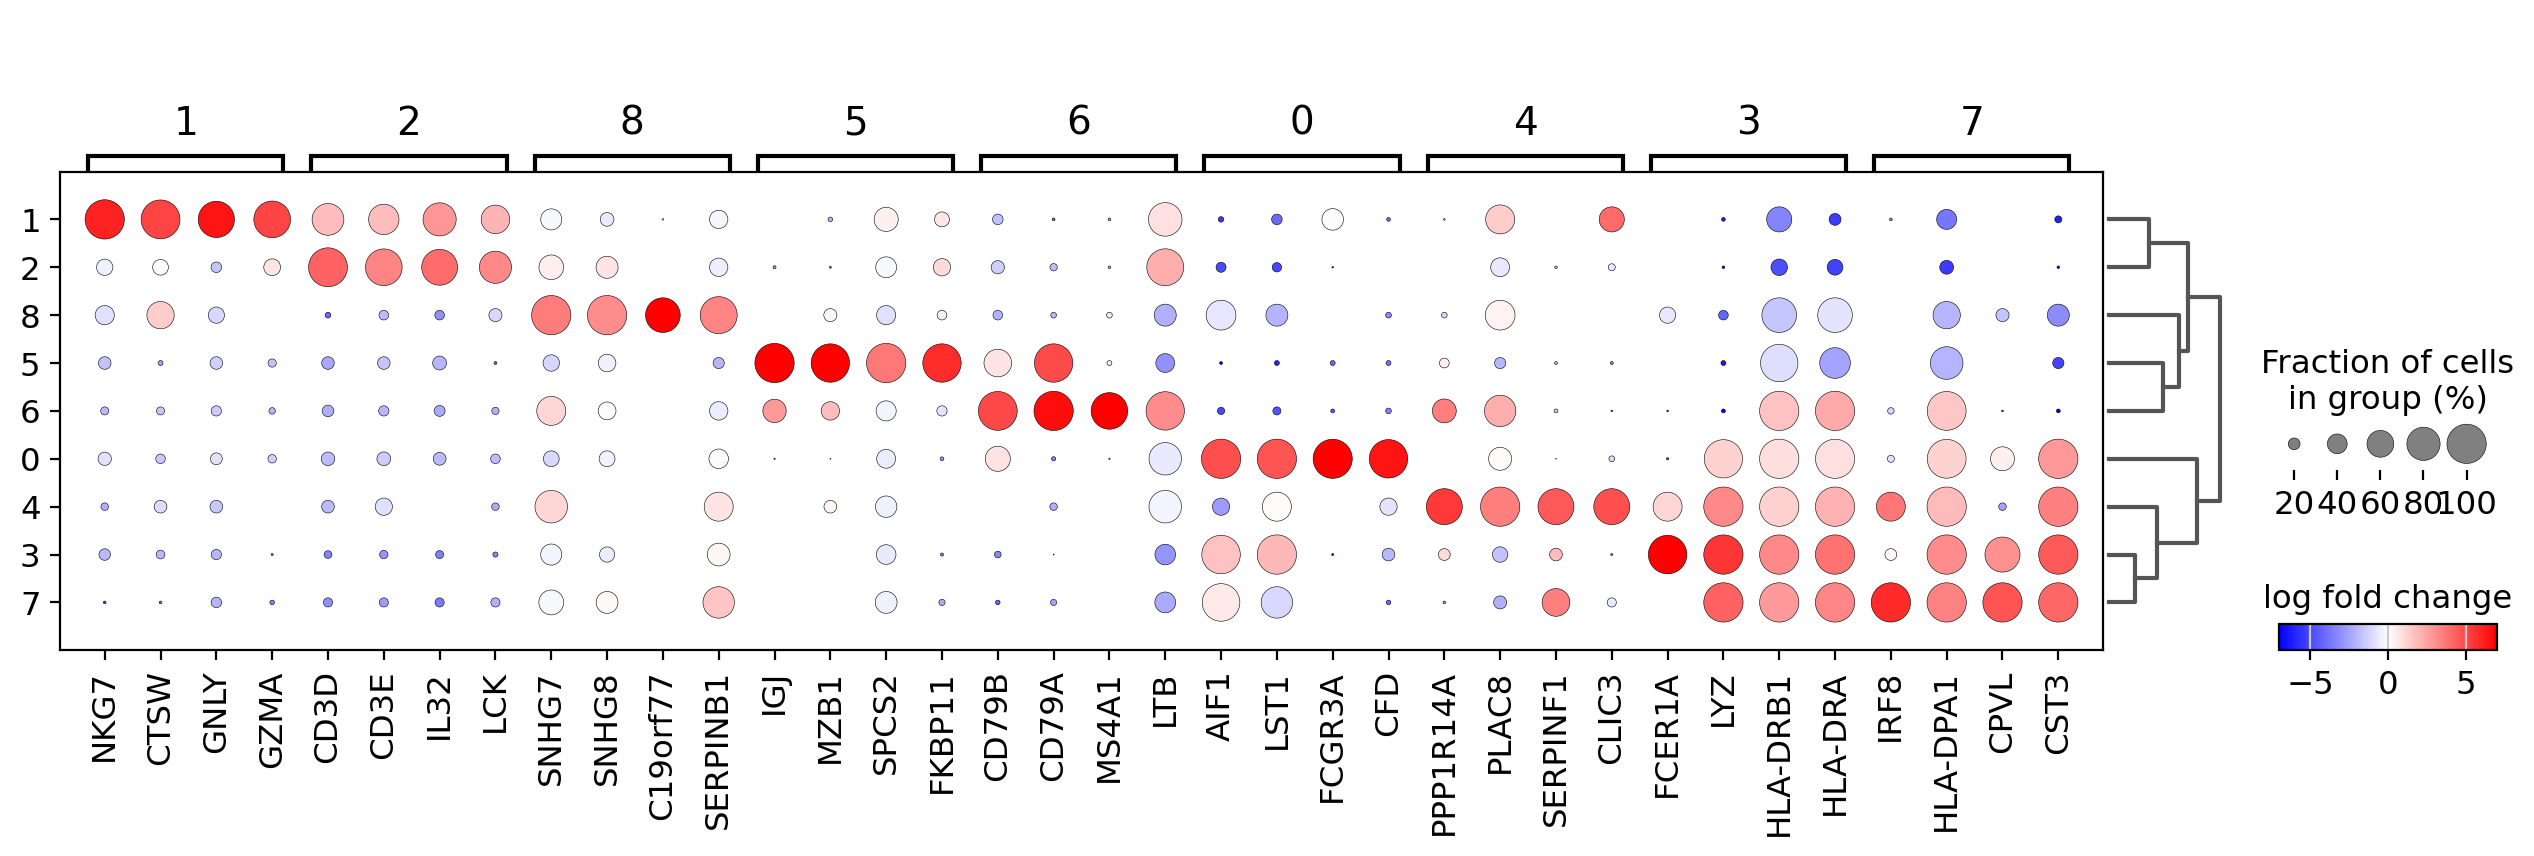

In [37]:
sc.pl.rank_genes_groups_dotplot(
    pbmc,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    save="_tut"
)

categories: 0, 1, 2, etc.
var_group_labels: 3, 7


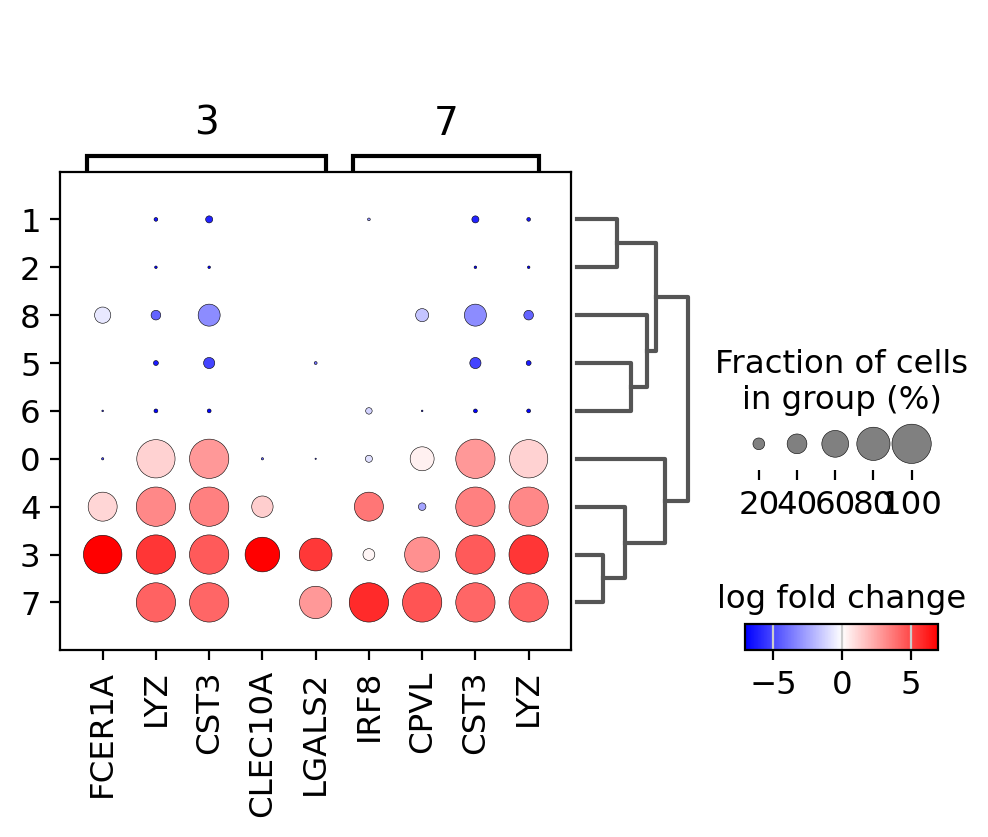

In [38]:
sc.pl.rank_genes_groups_dotplot(
    pbmc,
    n_genes=30,
    values_to_plot="logfoldchanges",
    min_logfoldchange=4,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groups=["3", "7"],
    save="_tut"
)

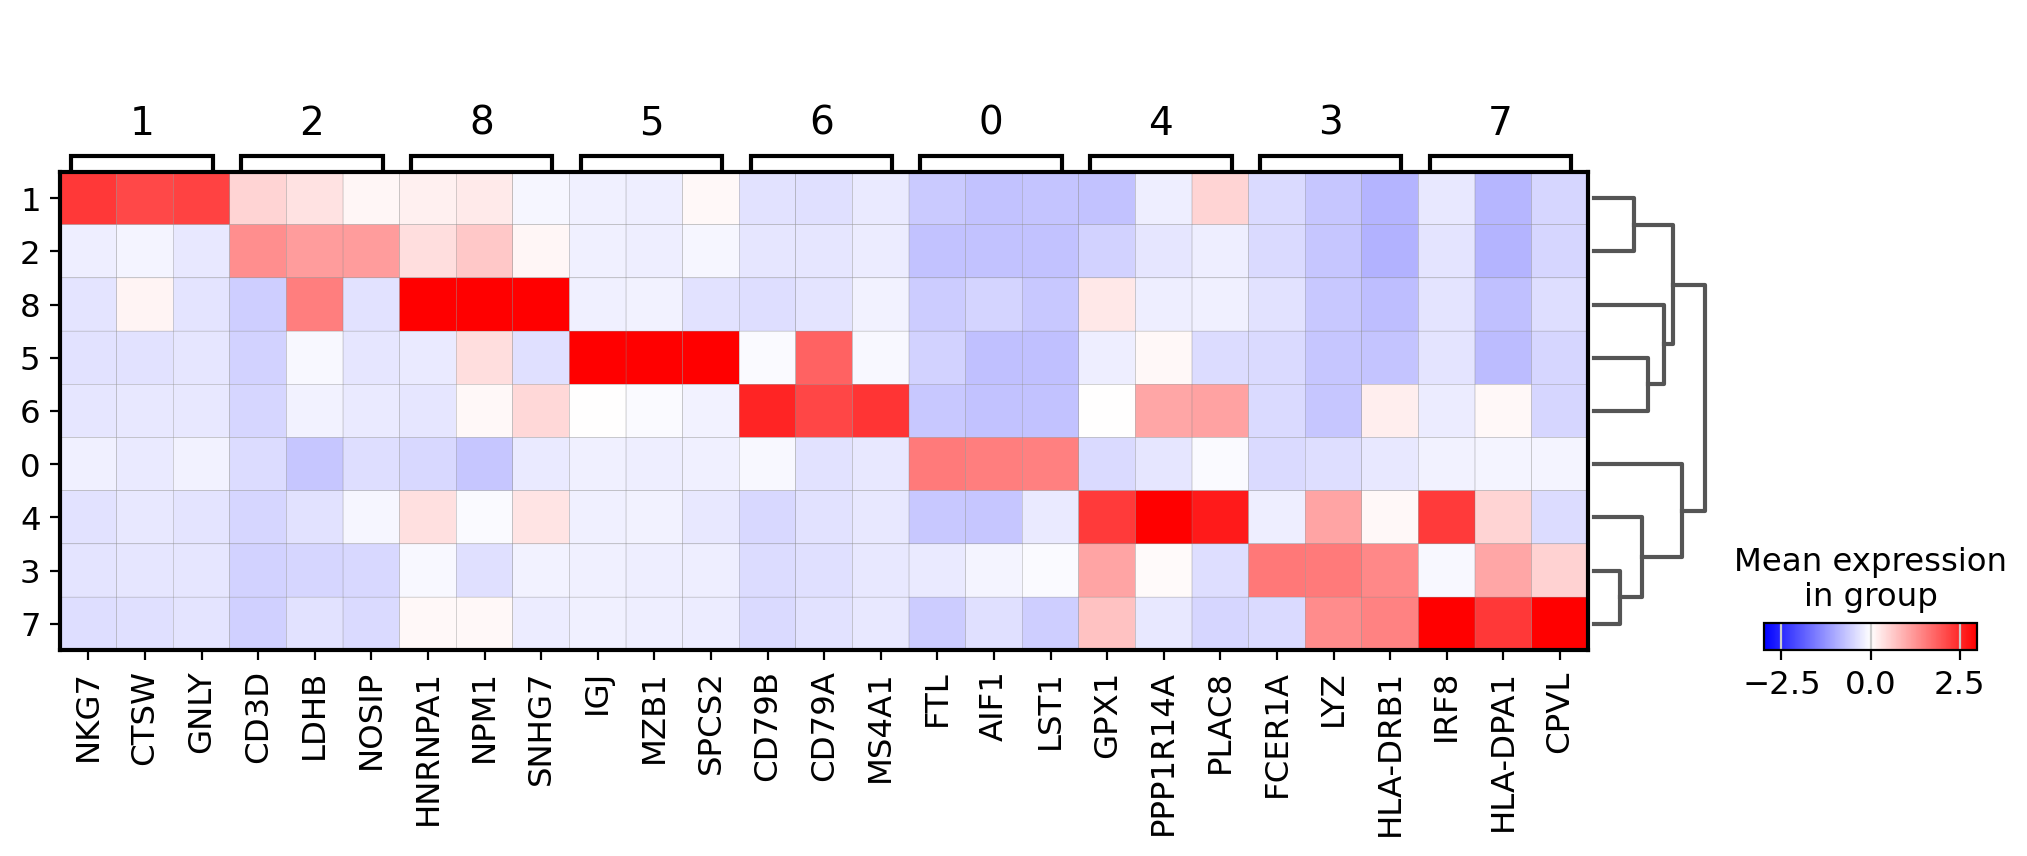

In [39]:
sc.pl.rank_genes_groups_matrixplot(
    pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap="bwr", layer="scaled", save="_tut"
)

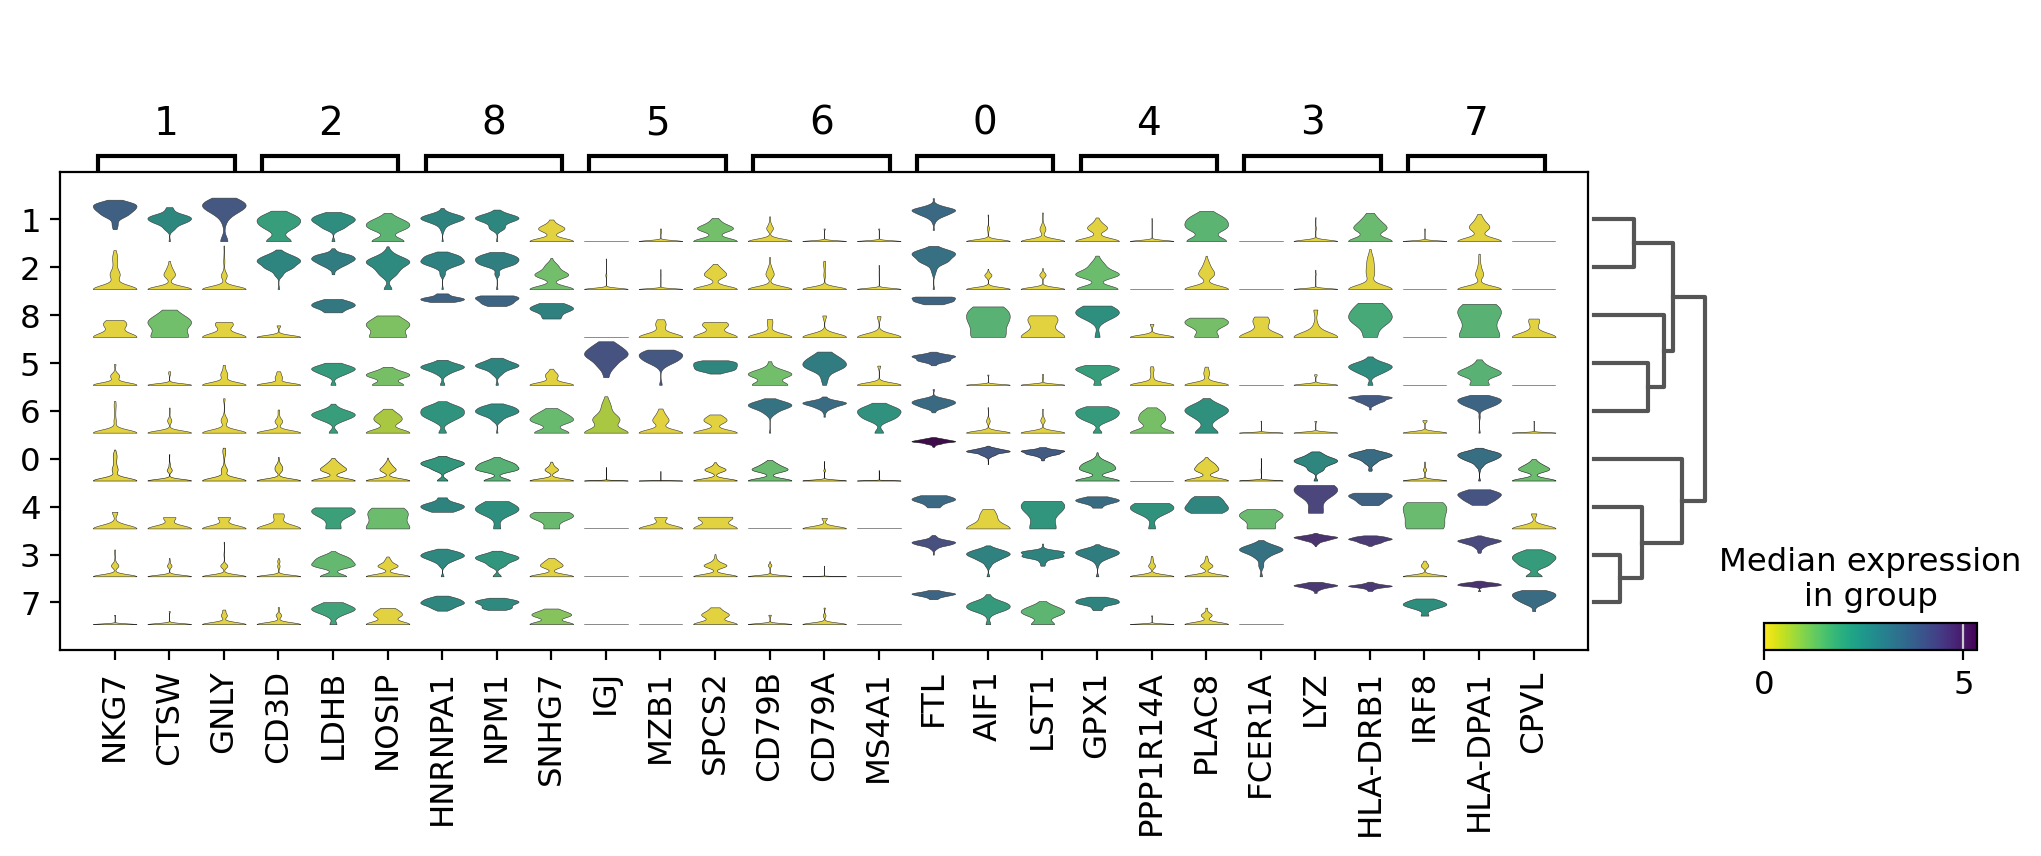

In [40]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap="viridis_r", save="_tut")

In [41]:
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=3,
    use_raw=False,
    swap_axes=True,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    layer="scaled",
    figsize=(10, 7),
    show=False,
    save="_tut"
);

In [44]:
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=3,
    use_raw=False,
    swap_axes=True,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    layer="scaled",
    figsize=(10, 7),
    show=False,
    save="_tut_rank_genes_groups"
);